In [ ]:
#%%  Import all the packages needed to explore grib data
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy

from pathlib  import Path

import sys
# insert path to src folder no matter from where the notebook is run
sys.path.insert(0, "..")

# import my stuff:
from src.plotting.plot_ens import (colors_ens, plot_ens_lineplot,get_country_record,
                                   plot_ens_tripleplot)
from src.data_loading.load_ens import (calculate_wind_speed,
                                       load_ens_data_ED)
from src.preprocessing.reducers import  average_over_shape 
# auto reload imports
%load_ext autoreload
%autoreload 2
#%% wider plots
# wider plots
plt.rcParams['figure.figsize'] = [10, 5]
from IPython.core.interactiveshell import InteractiveShell
# just the last output
InteractiveShell.ast_node_interactivity = "last_expr"
import warnings
warnings.filterwarnings('ignore')

# =======================================
#%% Flags and directories
## Flags and directories
# =========================================
load_full_D = True
drop_wind_components = True
calculate_diffs = True
save_fig = False

validate_function = False
if validate_function:
    from src.tests.test_functions import validate_function_average_over_shape

dir_data = Path('../data/ecmwf-ens')
fn_E = dir_data /"mars_v05e_2017-01-02_Mon.grib"
fn_D = dir_data /"mars_v05d_2017-01-02_Mon.grib"

dir_fig = Path('../report/figures')

latlon_vienna = (48.2082, 16.3738)


In [2]:
#%% Load the data
## Load the data
# =========================================
ds, dsD = load_ens_data_ED(fn_E, fn_D,
                           load_full_D=True,
                           drop_wind_components=True,
                           temperature_in_C=True,
                           calculate_diffs=True
                           )



tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff


In [3]:
#%% print variables
## print variables
# =========================================
#print bold header and title
print("ECMWF ENS Extended data variables :\n")
print(f"{'var':6s} {'units':10s} {'long_name':30s}")
print("-"*50)
for v in ds.data_vars:
    # table format
    print(f"{v:6s} {ds[v].attrs['units']:10s} {ds[v].attrs['long_name']:30s}")


ECMWF ENS Extended data variables :

var    units      long_name                     
--------------------------------------------------
z      m**2 s**-2 Geopotential                  
sp     Pa         Surface pressure              
t2m    C          2 metre temperature           
ssrd   J m**-2/h  Δ Surface short-wave (solar) radiation downwards
strd   J m**-2/h  Δ Surface long-wave (thermal) radiation downwards
ssr    J m**-2/h  Δ Surface net short-wave (solar) radiation
ro     m          Runoff                        
stl4   C          Soil temperature level 4      
d2m    C          2 metre dewpoint temperature  
w10    m s**-1    10m wind speed                
w100   m s**-1    100m wind speed               


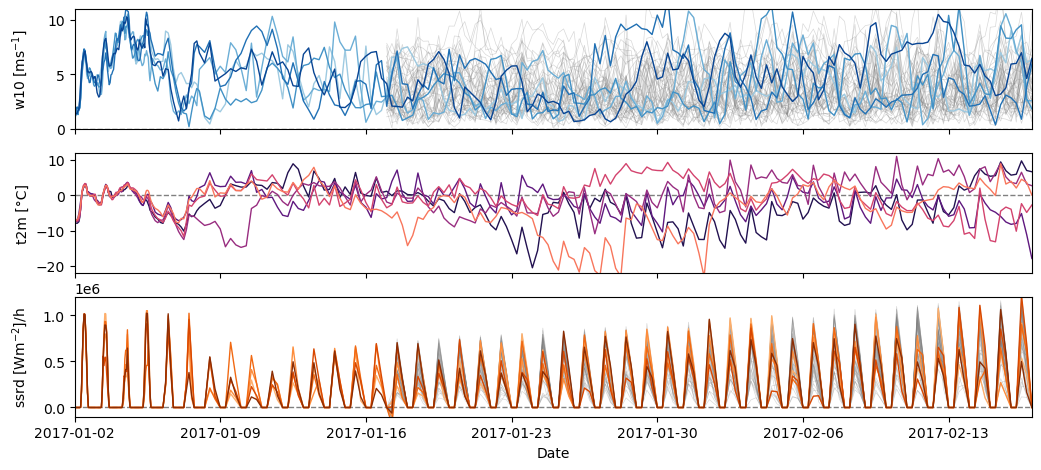

In [4]:
fig, axs = plt.subplots(3,1, figsize=(21/1.7,9/1.7), sharex=True)

plot_ens_lineplot(ds, "t2m", "point", dsD222=dsD, ax=axs[1],latlon=latlon_vienna,point_name="Vienna")
plot_ens_lineplot(ds, "w10", "point", dsD=dsD, ax=axs[0],latlon=latlon_vienna,point_name="Vienna")
plot_ens_lineplot(ds, "ssrd", "point", dsD=dsD, ax=axs[2],latlon=latlon_vienna,point_name="Vienna", show_xlabels=True)
axs[1].set_ylim(-22,12)
axs[0].set_ylim(0,11)
axs[2].set_ylim(-0.1e6,1.2e6)
# show the plot at lower dpi

axs[1].set_ylabel("t2m [°C]")
axs[0].set_ylabel("w10 [ms$^{-1}$]")
axs[2].set_ylabel("ssrd [Wm$^{-2}$]/h")

# label the whole figure with the location
# fig.text(0.5, 0.91, "ENS Extended past forecast for Vienna", ha='center', va='center', fontsize=16)

# align ylabels of all subplots
fig.align_ylabels()
if save_fig:
    fig.savefig(dir_fig / "egu_01_ens_vienna.png", dpi=300, bbox_inches="tight")

Text(0.5, 0.98, '')

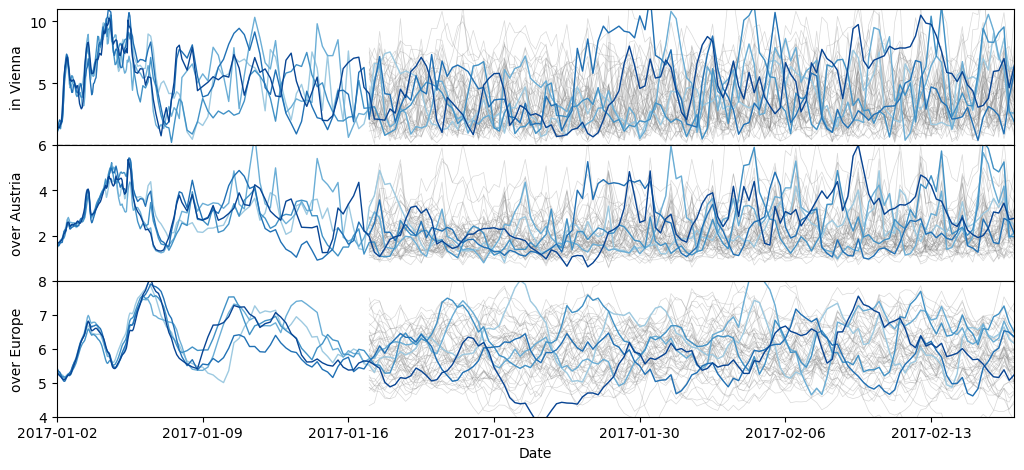

In [5]:
fig, axs = plt.subplots(3,1, figsize=(21/1.7,9/1.7), sharex=True)

plot_ens_tripleplot(ds, 'w10',dsD=dsD,plots = ["point","country","full_area"], country_name="Austria" , latlon=latlon_vienna, point_name='Vienna', ax=axs)

# label the whole figure with the location
# fig.text(0.5, 0.91, "ENS Extended past forecast for Vienna", ha='center', va='center', fontsize=16)
axs[0].set_ylim(0,11)
axs[1].set_ylim(0,6)
axs[2].set_ylim(4,8)
axs[0].set_ylabel("in Vienna")
axs[1].set_ylabel("over Austria")
axs[2].set_ylabel("over Europe")
axs[0].set_yticks([5,10])
axs[1].set_yticks([2,4,6])
axs[2].set_yticks([4,5,6,7,8])
# align ylabels of all subplots
fig.align_ylabels()
fig.suptitle("")
if save_fig:
    fig.savefig(dir_fig / "egu_02_ens_vienna_triple.png", dpi=300, bbox_inches="tight")

In [6]:
vars = ["t2m","d2m","stl4","ssrd","strd","w10","w100"]

In [7]:

#calculate variance over number latitude and longitude
ds_var = ds[vars].isel(step=slice(None,269-121)).resample(step="1D").mean().var(dim=["number"]).mean(["latitude","longitude"])
ds_var_max = ds_var.max(dim="step")
ds_var = ds_var.assign_coords(valid_time=ds_var.step+ds_var.time)

#calculate variance over number latitude and longitude
dsD_var = dsD[vars].resample(step="1D").mean().var(dim=["number"]).mean(["latitude","longitude"])
dsD_var_max = dsD_var.max(dim="step")
dsD_var = dsD_var.assign_coords(valid_time=dsD_var.step+dsD_var.time)

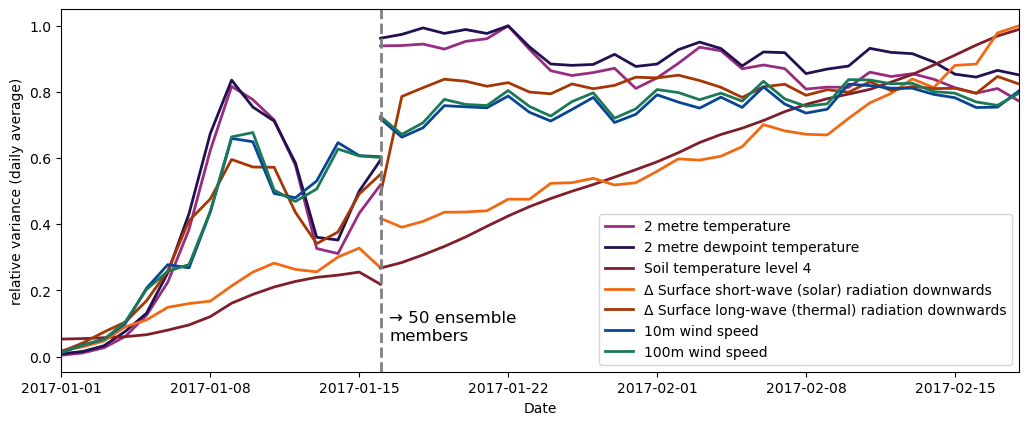

In [39]:
# Plot the variance for each variable as line plot
colors_dict = dict(t2m="#982d80",stl4="#801E29",d2m="#221150" ,ssrd="#f16913",strd="#a63603",w10="#084594",w100="#1c7958")
colors = [colors_dict[v] for v in vars]

fig,ax = plt.subplots(1,1,figsize=(21/1.7,8/1.7))
ax.set_prop_cycle(mpl.cycler(color=colors))
(ds_var/dsD_var_max).to_array(dim="variable").plot.line(x="valid_time", hue="variable", ax=ax, lw=2)
ax.set_prop_cycle(mpl.cycler(color=colors)) #reset color cycle for D data
(dsD_var/dsD_var_max).to_array(dim="variable").isel(step=slice(None,-1)).plot.line(x="valid_time", hue="variable", ax=ax, lw=2)

# set legend bottom right with long names
vars_long = [ds[v].long_name for v in vars]
ax.legend(loc="lower right", labels=vars_long)

ax.set_ylabel("relative variance (daily average)")
ax.set_xticklabels(ax.get_xticklabels(),rotation=0,ha="center")
date_range = ds.valid_time.values.min(), ds.valid_time.values.max()-pd.Timedelta("1D")

# set xticks to every 7 days starting at 2017-01-02
ax.set_xticks(pd.date_range(*date_range,freq="7D"))
ax.set_xlim(*date_range)

ax.set_title("")
ax.set_xlabel("Date")

# plot vertical grey dashed line before the first valid time of the D data
cutoff = dsD.valid_time[0].values
ax.axvline(cutoff, color="grey", linestyle="--", linewidth=2)
# add a small text right of this line "→ 50 ensemble members"
ax.text(cutoff + np.timedelta64(10, 'h'), 0.05, "→ 50 ensemble\nmembers", fontsize=12)

if save_fig:
    fig.savefig(dir_fig / "egu_03_ens_var.png", dpi=300, bbox_inches="tight")

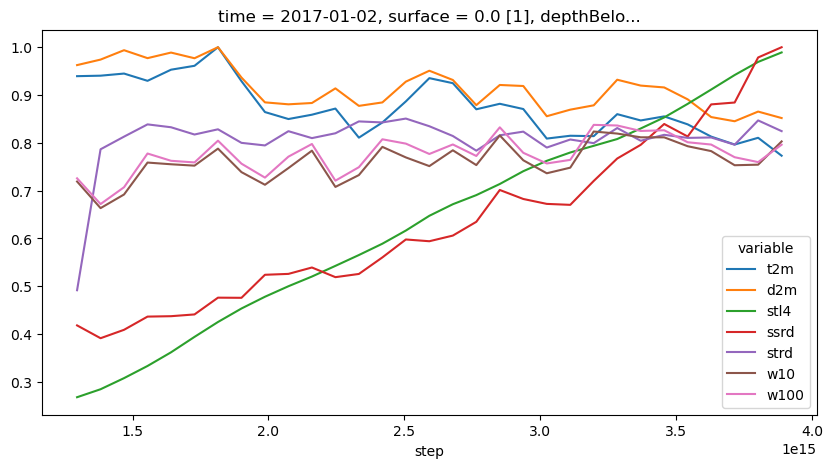

In [9]:
# plot the variance for each variable as line plot
(dsD_var/dsD_var_max).to_array(dim="variable").isel(step=slice(None,-1)).plot.line(x="step", hue="variable")

In [10]:
ds.valid_time.values.min(), ds.valid_time.values.max()

(numpy.datetime64('2017-01-02T00:00:00.000000000'),
 numpy.datetime64('2017-02-17T00:00:00.000000000'))

In [11]:
#%% Load the data
## Load the data
# =========================================
def extract_var(date):
    fn2_E = dir_data / f"mars_v0{date[0]}e{date[1:]}.grib"
    fn2_D = dir_data / f"mars_v0{date[0]}d{date[1:]}.grib"
    ds2, dsD2 = load_ens_data_ED(fn2_E, fn2_D,
                            load_full_D=True,
                            drop_wind_components=True,
                            temperature_in_C=True,
                            calculate_diffs=True
                            )

    #calculate variance over number latitude and longitude
    ds2_var = ds2[vars].isel(step=slice(None,269-121)
                            ).resample(step="1D").mean(
                                ).var(dim=["number"]
                                    ).mean(["latitude","longitude"])
    ds2_var = ds2_var.assign_coords(valid_time=ds_var.step+ds_var.time)

    #calculate variance over number latitude and longitude
    dsD2_var = dsD2[vars].resample(step="1D").mean().var(dim=["number"]
                        ).mean(["latitude","longitude"])
    dsD2_var_max = dsD2_var.max(dim="step")
    dsD2_var = dsD2_var.assign_coords(valid_time=dsD_var.step+dsD_var.time)
    del ds2, dsD2
    return ds2_var, dsD2_var

In [12]:
# dates= ["5_2017-01-05_Thu","5_2017-01-09_Mon",
#         "5_2017-01-12_Thu","5_2017-01-16_Mon",
#         "5_2017-01-19_Thu","5_2017-01-24_Mon",
#         "5_2017-01-05_Thu","5_2017-01-09_Mon"]
dates = ["5_2017-01-12_Thu","5_2017-01-16_Mon","5_2017-01-19_Thu"]

variances = [extract_var(date) for date in dates]

tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff
tp not in dataset to calculate diff
tcc not in dataset to calculate diff


In [18]:
def normalize_var(varE, varD):
    var_max = varD.max(dim="step")
    return varE/var_max, varD/var_max

In [19]:
variances_norm = [normalize_var(varE, varD) for varE, varD in variances]

In [28]:
variancesE = [varE for varE, varD in variances_norm]
variancesD = [varD for varE, varD in variances_norm]
variancesE.append(ds_var/dsD_var_max)
variancesD.append(dsD_var/dsD_var_max)

In [30]:
ds2_var = xr.concat(variancesE, dim="run").mean(dim="run")
dsD2_var = xr.concat(variancesD, dim="run").mean(dim="run")

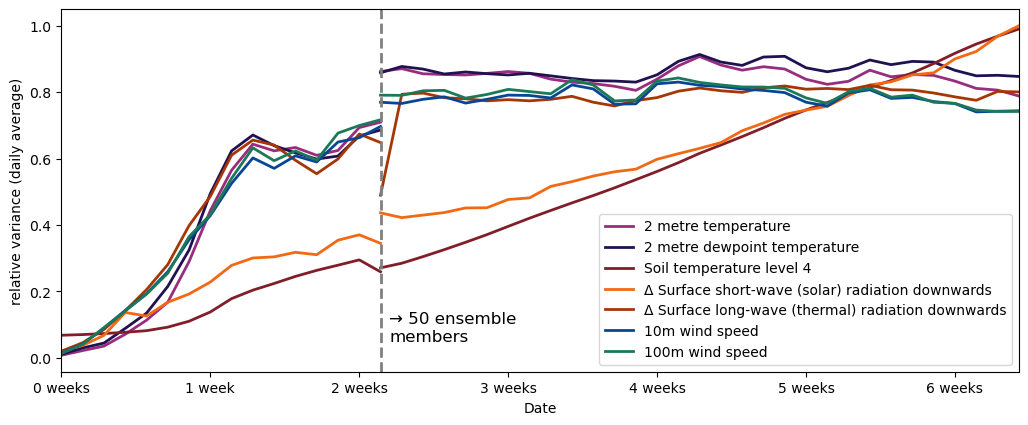

In [38]:
colors_dict = dict(t2m="#982d80",stl4="#801E29",d2m="#221150" ,ssrd="#f16913",strd="#a63603",w10="#084594",w100="#1c7958")
colors = [colors_dict[v] for v in vars]

fig,ax = plt.subplots(1,1,figsize=(21/1.7,8/1.7))
ax.set_prop_cycle(mpl.cycler(color=colors))
(ds2_var).to_array(dim="variable").plot.line(x="valid_time", hue="variable",ax=ax, linewidth=2)
ax.set_prop_cycle(mpl.cycler(color=colors)) #reset color cycle
(dsD2_var).to_array(dim="variable").isel(step=slice(None,-1)).plot.line(x="valid_time", hue="variable", ax=ax, linewidth=2)

# set legend bottom right with long names
vars_long = [ds[v].long_name for v in vars]
ax.legend(loc="lower right", labels=vars_long)
ax.set_ylabel("relative variance (daily average)")

date_range = ds.valid_time.values.min(), ds.valid_time.values.max()-pd.Timedelta("1D")
# set xticks to every 7 days starting at 2017-01-02
ax.set_xticks(pd.date_range(*date_range,freq="7D"))
xticklabels=["0 weeks","1 week", "2 weeks", "3 weeks", "4 weeks", "5 weeks", "6 weeks"]
ax.set_xticklabels(xticklabels,rotation=0,ha="center")
ax.set_xlim(*date_range)

ax.set_xlabel("Date")
ax.set_title("")

# plot vertical grey dashed line before the first valid time of the D data
cutoff = dsD.valid_time[0].values
ax.axvline(cutoff, color="grey", linestyle="--", linewidth=2)
# add a small text right of this line "→ 50 ensemble members"
ax.text(cutoff + np.timedelta64(10, 'h'), 0.05, "→ 50 ensemble\nmembers", fontsize=12)

if save_fig:
    fig.savefig(dir_fig / "egu_04_ens_var_month.png", dpi=300, bbox_inches="tight")

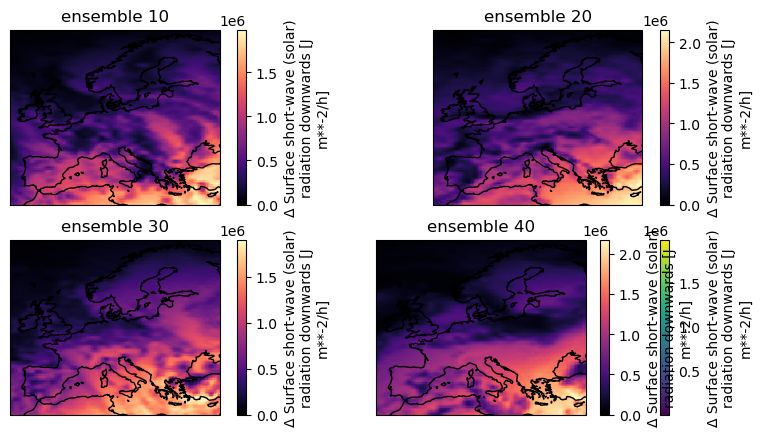

In [61]:
## Examples of visual plots (unfinished)
# european projection
fig,axs =plt.subplots(2,2, subplot_kw={"projection": ccrs.PlateCarree()})
dsD.ssrd.isel(step=102,number=10).plot()
for i, ens in enumerate([10,20,30,40]):
    # select the axis to plot to
    ax = axs.flatten()[i]
    # plot with colorbar from 0 to max
    dsD.isel(number=ens, step=102)["ssrd"].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap="magma", vmin=0,vmax=2e6)
    # add title
    ax.set_title(f"ensemble {ens}")
    # add coastlines in white
    ax.coastlines()
    # add gridlines
    #remov
# print the step da